In [1]:
!pip install opencv-python matplotlib numpy tensorflow Pillow scikit-learn torch torchvision

In [2]:
!pip install ultralytics
!pip install roboflow

In [3]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from xml.etree.ElementTree import parse
from PIL import Image, ImageDraw
from glob import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, BatchNormalization, Add, Multiply
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch
# from ultralytics import YOLO

2025-05-17 19:29:27.034389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747510167.048239   62883 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747510167.052685   62883 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747510167.064481   62883 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747510167.064493   62883 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747510167.064495   62883 computation_placer.cc:177] computation placer alr

In [4]:
# !pip install roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="FPwNMetcViL78rFFqLNr")
project = rf.workspace("harshit-ranjan-yr3qt").project("miniproject-gum6t")
dataset = project.version(2).download("coco-segmentation")

loading Roboflow workspace...


loading Roboflow project...


In [5]:
pip install pycocotools

Note: you may need to restart the kernel to use updated packages.


In [6]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import os

def visualize_coco_annotations(coco_json_path, image_dir, num_images=5):
    coco = COCO(coco_json_path)
    image_ids = coco.getImgIds()

    for img_id in image_ids[:num_images]:
        img_info = coco.loadImgs(img_id)[0]
        image_path = os.path.join(image_dir, img_info['file_name'])

        if not os.path.exists(image_path):
            print(f"[Warning] Image not found: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"[Error] Failed to load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        coco.showAnns(anns)
        plt.title(img_info['file_name'])
        plt.show()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


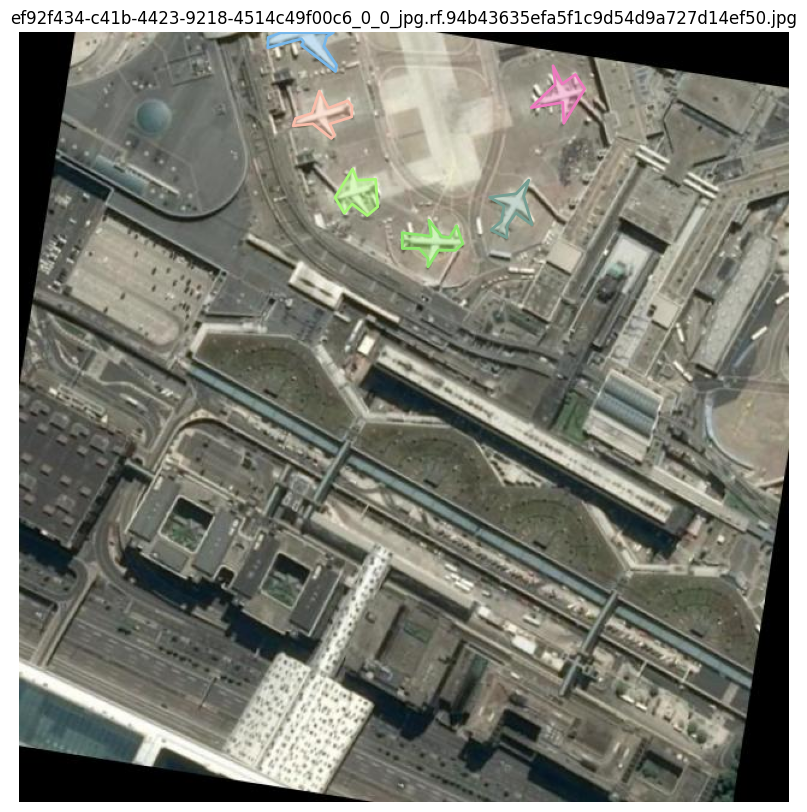

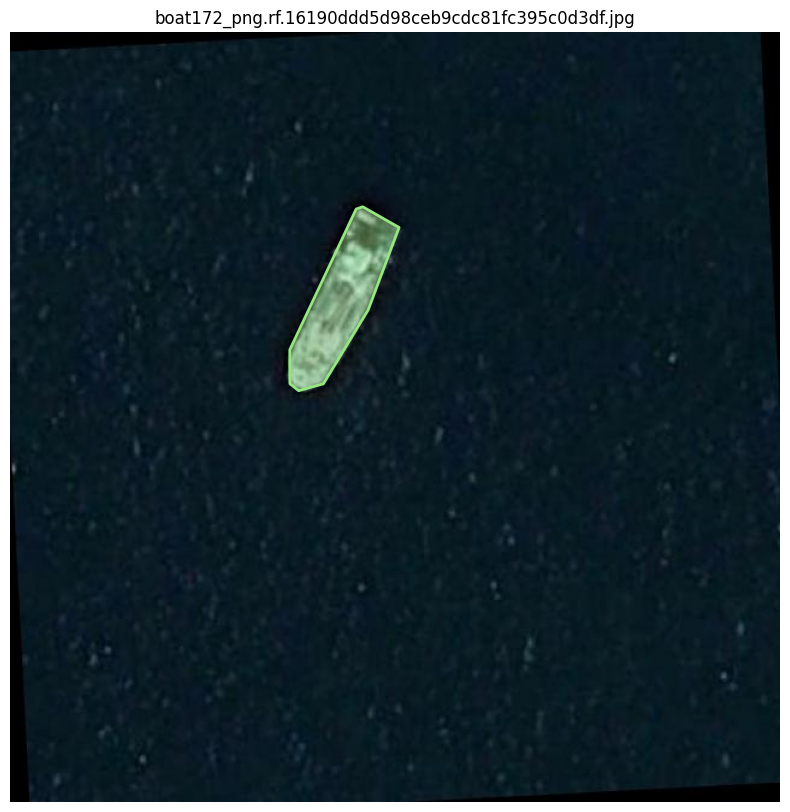

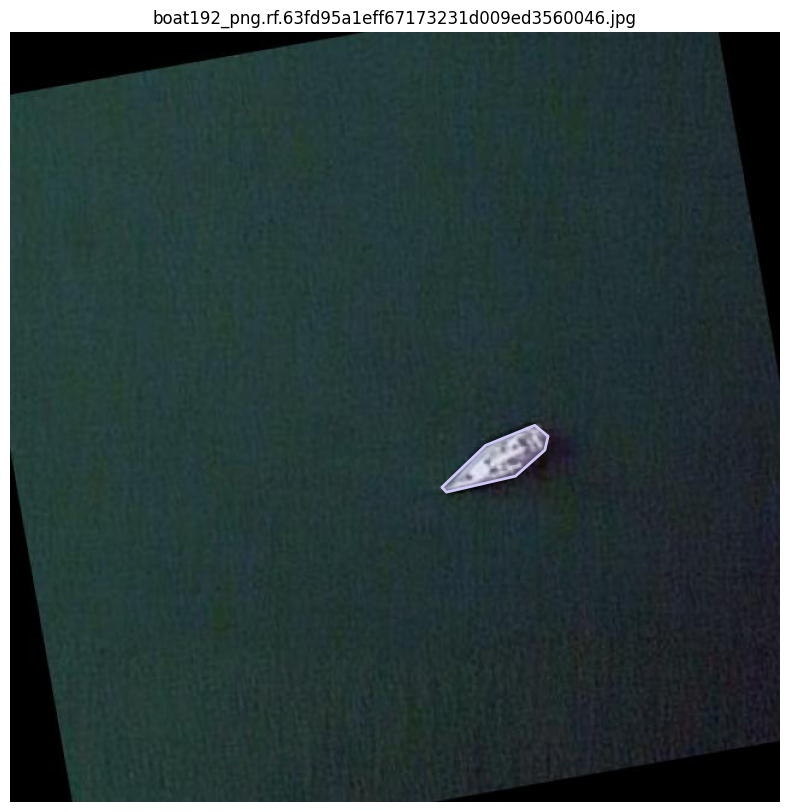

In [7]:
visualize_coco_annotations(
    coco_json_path="/teamspace/studios/this_studio/MiniProject-2/train/_annotations.coco.json",
    image_dir="/teamspace/studios/this_studio/MiniProject-2/train",
    num_images=3
)

In [8]:
def visualize_sample_images(image_paths, xml_paths, num_samples=5):
    plt.figure(figsize=(50, 50))

    for i in range(num_samples):
        image = visualize_annotations(image_paths[i], xml_paths[i])

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Sample {i+1}')

    plt.show()

In [9]:
from pycocotools.coco import COCO
import numpy as np
import os
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def create_coco_mask(coco: COCO, img_id: int, image_size: tuple, use_category_id=True):
    anns_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(anns_ids)

    height, width = image_size[1], image_size[0]
    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        ann_mask = coco.annToMask(ann)  # returns binary mask of shape (H, W)
        if ann_mask.shape != (height, width):
            ann_mask = cv2.resize(ann_mask, (width, height), interpolation=cv2.INTER_NEAREST)
        
        if use_category_id:
            category_id = ann['category_id']
            if category_id == 1:  # Aircraft
                mask[ann_mask == 1] = 1
            elif category_id == 2:  # Ship
                mask[ann_mask == 1] = 2
            # Add more conditions if you have other classes.
        else:
            mask = np.maximum(mask, ann_mask.astype(np.uint8))

    return mask

In [10]:
def load_data(image_dir, coco_json_path, input_size=(256, 256), use_category_id=True, limit=None):
    coco = COCO(coco_json_path)
    image_ids = coco.getImgIds()
    if limit:
        image_ids = image_ids[:limit]

    images, masks = [], []

    for img_id in image_ids:
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info["file_name"]
        img_path = os.path.join(image_dir, file_name)

        if not os.path.exists(img_path):
            print(f"[Warning] Missing image: {img_path}")
            continue

        # Load and preprocess image
        img = load_img(img_path, target_size=input_size)
        img = img_to_array(img) / 255.0

        # Generate mask
        mask = create_coco_mask(coco, img_id, input_size, use_category_id)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension for masks

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


In [11]:
from PIL import Image
import numpy as np

def predict_mask(model, image_path, target_size=(256, 256)):
    # Load and resize image
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    original_image = np.array(img)

    # Normalize and expand dims
    input_img = original_image.astype(np.float32) / 255.0
    input_tensor = np.expand_dims(input_img, axis=0)  # shape: (1, 256, 256, 3)

    # Predict
    prediction = model.predict(input_tensor)[0]  # shape: (256, 256, 3)

    # Convert softmax outputs to class index mask
    predicted_mask = np.argmax(prediction, axis=-1)  # shape: (256, 256)

    return original_image, predicted_mask


In [12]:
def plot_training_history(history):
    # Extract accuracy and loss values for both training and validation sets
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
image_dir = "/teamspace/studios/this_studio/MiniProject-2/train"
coco_json_path = "/teamspace/studios/this_studio/MiniProject-2/train/_annotations.coco.json"
input_size = (256, 256)

In [14]:
# Load data
images, masks = load_data(image_dir, coco_json_path, input_size)
print(f"Loaded {len(images)} images and {len(masks)} masks.")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded 306 images and 306 masks.


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import backend as K

In [16]:
import tensorflow.keras.backend as K
import tensorflow as tf

def multiclass_dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Clip predictions to avoid log(0) or divide-by-zero
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)

    axes = [1, 2]  # sum across height and width
    intersection = tf.reduce_sum(y_true * y_pred, axis=axes)
    denominator = tf.reduce_sum(y_true + y_pred, axis=axes)

    dice = (2. * intersection + smooth) / (denominator + smooth)
    dice_loss = 1 - dice

    return tf.reduce_mean(dice_loss)  # average over batch and classes


In [17]:
from tensorflow.keras.layers import Conv2D, Multiply, Add, Activation, UpSampling2D, MaxPooling2D, concatenate, Input
from tensorflow.keras.models import Model
import tensorflow as tf

def attention_block(x, gating, inter_shape):
    theta_x = Conv2D(inter_shape, (1, 1), strides=1, padding='same')(x)
    phi_g = Conv2D(inter_shape, (1, 1), strides=1, padding='same')(gating)

    if theta_x.shape[1] != phi_g.shape[1] or theta_x.shape[2] != phi_g.shape[2]:
        scale_h = tf.shape(theta_x)[1] // tf.shape(phi_g)[1]
        scale_w = tf.shape(theta_x)[2] // tf.shape(phi_g)[2]
        phi_g = UpSampling2D(size=(scale_h, scale_w), interpolation='bilinear')(phi_g)

    concat_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)

    y = Multiply()([x, sigmoid_xg])

    return y

In [18]:
def attention_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder with Attention
    up6 = UpSampling2D(size=(2, 2))(conv5)
    attn6 = attention_block(conv4, up6, 512)
    merge6 = concatenate([up6, attn6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    attn7 = attention_block(conv3, up7, 256)
    merge7 = concatenate([up7, attn7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    attn8 = attention_block(conv2, up8, 128)
    merge8 = concatenate([up8, attn8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    attn9 = attention_block(conv1, up9, 64)
    merge9 = concatenate([up9, attn9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Final layer: 3-class output
    outputs = Conv2D(3, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [19]:
# Instantiate the model
AU_model = attention_unet()
AU_model.summary()

I0000 00:00:1747510175.540920   62883 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    262,656 │ conv2d_7[0][0]  

 Total params: 32,426,439 (123.70 MB)

 Trainable params: 32,426,439 (123.70 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [21]:
AU_model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [22]:
history = AU_model.fit(
    X_train,Y_train,
    epochs=30,
    validation_data=(X_val, Y_val)
)

Epoch 1/30


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))


I0000 00:00:1747510181.493857   64797 service.cc:152] XLA service 0x7f14000023c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747510181.493886   64797 service.cc:160]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-05-17 19:29:41.634059: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-17 19:29:41.981886: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1747510182.476854   64797 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-05-17 19:29:59.692006: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 26.34GiB with freed_by_count=0. The caller indicates that this is not a failure, b

7/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6296 - loss: 17.7843

2025-05-17 19:31:21.861755: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-05-17 19:31:34.441323: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 25.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-17 19:31:36.899300: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 26.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-17 19:31:39.590964: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 27.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6579 - loss: 17.4437

2025-05-17 19:32:28.675047: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-05-17 19:32:56.628959: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bias-activation.129 = (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,256,256]{3,2,1,0} %bitcast.2180, f32[64,192,3,3]{3,2,1,0} %bitcast.2187, f32[64]{0} %bitcast.2189), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_28_1/convolution" source_file="/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":

8/8 ━━━━━━━━━━━━━━━━━━━━ 235s 20s/step - accuracy: 0.6799 - loss: 17.1788 - val_accuracy: 0.9785 - val_loss: 0.9671
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9783 - loss: 0.8168 - val_accuracy: 0.9785 - val_loss: 0.1890
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9788 - loss: 0.1810 - val_accuracy: 0.9785 - val_loss: 0.1531
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9769 - loss: 0.1560 - val_accuracy: 0.9785 - val_loss: 0.1273
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9777 - loss: 0.1313 - val_accuracy: 0.9785 - val_loss: 0.1112
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9788 - loss: 0.1102 - val_accuracy: 0.9785 - val_loss: 0.0991
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9790 - loss: 0.1049 - val_accuracy: 0.9785 - val_loss: 0.0970
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9785 - loss: 0.0999 - val_accuracy: 0.9785 - val_loss: 0.0937
Epoch 9/30
8/8 ━━━━━━━━

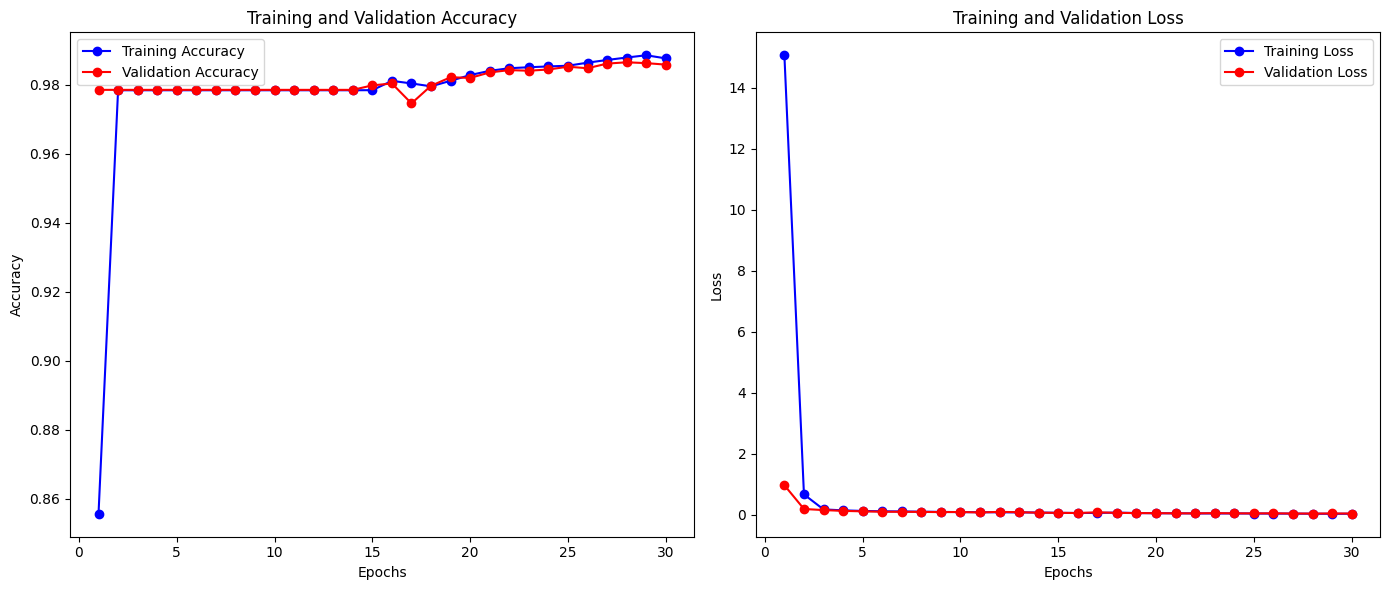

In [23]:
plot_training_history(history)

In [24]:
AU_model.save("attention_unet_model.keras")

In [25]:
from tensorflow.keras.models import load_model

AU_model = load_model("attention_unet_model.keras", custom_objects={
    'attention_block': attention_block,
})
# Compile (needed if you're going to evaluate)
AU_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate on proper data
loss, acc = AU_model.evaluate(X_val, Y_val)
print("Restored model accuracy:", acc) 

2025-05-17 19:37:50.461351: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.9845 - loss: 0.0437

2025-05-17 19:37:51.613015: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9854 - loss: 0.0412
Restored model accuracy: 0.9858314990997314


In [26]:
# Evaluate the fine-tuned model on the validation set
val_loss, val_accuracy = AU_model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.9854 - loss: 0.0412
Validation Loss: 0.0400
Validation Accuracy: 0.9858


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step - accuracy: 0.9854 - loss: 0.0412
Validation Loss: 0.0400, Validation Accuracy: 0.9858
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Unique values in true_class_mask: [0 1]
Unique values in predicted_class_mask: [0 1]


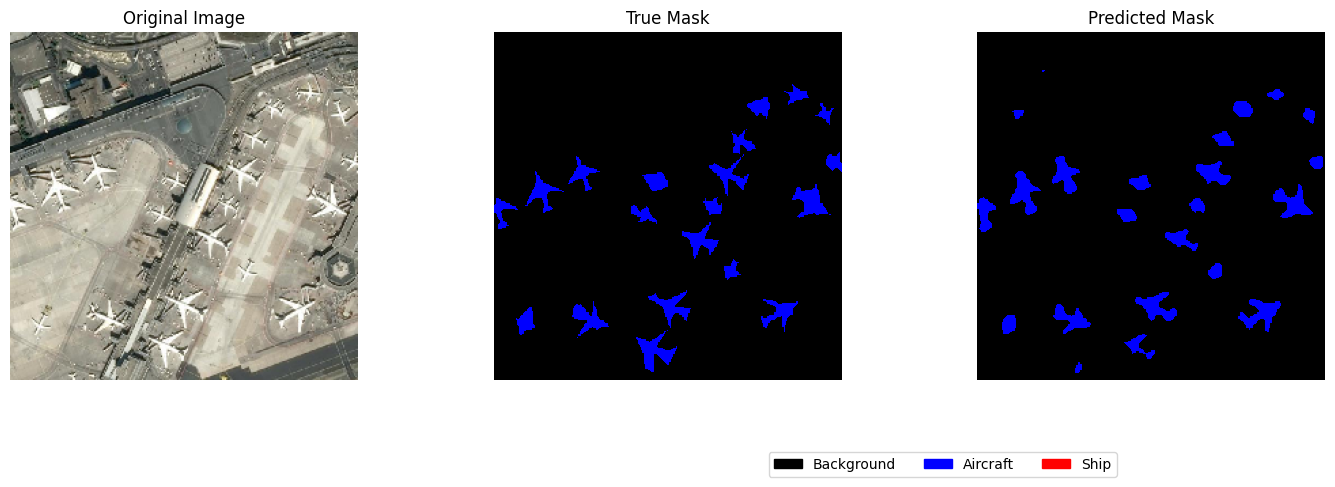

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Evaluate model
loss, accuracy = AU_model.evaluate(X_val, Y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Select sample
sample_index = 2
sample_image = X_val[sample_index]             # shape: (256, 256, 3)
true_class_mask = Y_val[sample_index]          # shape: (256, 256) — class indices
predicted_mask = AU_model.predict(np.expand_dims(sample_image, axis=0))[0]  # (256, 256, 3)
predicted_class_mask = np.argmax(predicted_mask, axis=-1)                   # (256, 256)

# Debug info
print("Unique values in true_class_mask:", np.unique(true_class_mask))
print("Unique values in predicted_class_mask:", np.unique(predicted_class_mask))

# Define colormap for 3 classes
cmap = mcolors.ListedColormap(['black', 'blue', 'red'])  # 0=BG, 1=Boat, 2=Aircraft
legend_labels = [
    mpatches.Patch(color='black', label='Background'),
    mpatches.Patch(color='blue', label='Aircraft'),
    mpatches.Patch(color='red', label='Ship'),
]

# Plot
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_class_mask, cmap=cmap, vmin=0, vmax=2)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_class_mask, cmap=cmap, vmin=0, vmax=2)
plt.axis("off")

plt.tight_layout()
plt.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(-0.1, -0.3), ncol=3)
plt.show()


In [28]:
# Predict without thresholding and inspect values
raw_predicted_mask = AU_model.predict(np.expand_dims(sample_image, axis=0))[0]
print("Predicted mask values (before thresholding):", raw_predicted_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted mask values (before thresholding): [[[9.16691184e-01 6.02494515e-02 2.30593532e-02]
  [9.77404118e-01 1.98885053e-02 2.70737475e-03]
  [9.83696103e-01 1.54894432e-02 8.14511557e-04]
  ...
  [9.67584491e-01 2.63718851e-02 6.04367256e-03]
  [9.55803990e-01 3.34833562e-02 1.07126981e-02]
  [9.02200222e-01 5.67822456e-02 4.10176069e-02]]

 [[9.83470201e-01 1.39133800e-02 2.61637778e-03]
  [9.95595634e-01 4.28691460e-03 1.17445714e-04]
  [9.96167481e-01 3.81188677e-03 2.06773875e-05]
  ...
  [9.92908955e-01 6.68073818e-03 4.10376233e-04]
  [9.91165340e-01 7.94350635e-03 8.91138916e-04]
  [9.73922729e-01 1.85507517e-02 7.52647966e-03]]

 [[9.90392089e-01 8.46692640e-03 1.14095106e-03]
  [9.96945441e-01 3.00883106e-03 4.56996713e-05]
  [9.96300340e-01 3.69127514e-03 8.32652222e-06]
  ...
  [9.95383441e-01 4.41790977e-03 1.98589434e-04]
  [9.95254099e-01 4.41283407e-03 3.32983065e-04]
  [9.86925602e-01 9.98195913e-03 3.09247151e-03]]

 ...

 [[9.

In [29]:
# Unfreeze the last 10 layers of the base model for fine-tuning
for layer in AU_model.layers[-10:]:
    layer.trainable = True

In [30]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + tf.keras.backend.epsilon()) / (denominator + tf.keras.backend.epsilon())

AU_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy'])

In [31]:
import tensorflow as tf

def sparse_dice_loss(y_true, y_pred, smooth=1e-6):
    # Remove last dimension if necessary (from (B, H, W, 1) to (B, H, W))
    y_true = tf.squeeze(y_true, axis=-1)  

    # Dynamically detect number of classes from y_pred
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Clip predictions to avoid NaNs
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)

    # Compute Dice score per class
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2])
    dice_score = (2. * intersection + smooth) / (denominator + smooth)

    # Final loss: 1 - mea
    # n dice over batch and classes
    return 1.0 - tf.reduce_mean(dice_score)

In [32]:
def combined_loss(y_true, y_pred):
    scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    dice = sparse_dice_loss(y_true, y_pred)
    return scce + 0.5 * dice

In [33]:
from tensorflow.keras.optimizers import Adam

AU_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=['accuracy']
)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [35]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

history = AU_model.fit(
    X_train,Y_train,
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50


2025-05-17 19:38:03.186699: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


3/8 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9872 - loss: 0.2826  

7/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9878 - loss: 0.2756

2025-05-17 19:38:15.487705: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9879 - loss: 0.2745

2025-05-17 19:38:21.574387: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-05-17 19:38:22.851603: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9879 - loss: 0.2737 - val_accuracy: 0.9870 - val_loss: 0.2830 - learning_rate: 1.0000e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9894 - loss: 0.2574 - val_accuracy: 0.9872 - val_loss: 0.2725 - learning_rate: 1.0000e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9893 - loss: 0.2542 - val_accuracy: 0.9862 - val_loss: 0.2746 - learning_rate: 1.0000e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9901 - loss: 0.2532 - val_accuracy: 0.9858 - val_loss: 0.2710 - learning_rate: 1.0000e-04
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9894 - loss: 0.2496 - val_accuracy: 0.9857 - val_loss: 0.2721 - learning_rate: 1.0000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9884 - loss: 0.2549 - val_accuracy: 0.9874 - val_loss: 0.2698 - learning_rate: 1.0000e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9898 - loss: 0.2467 - val_accuracy: 0.9874 

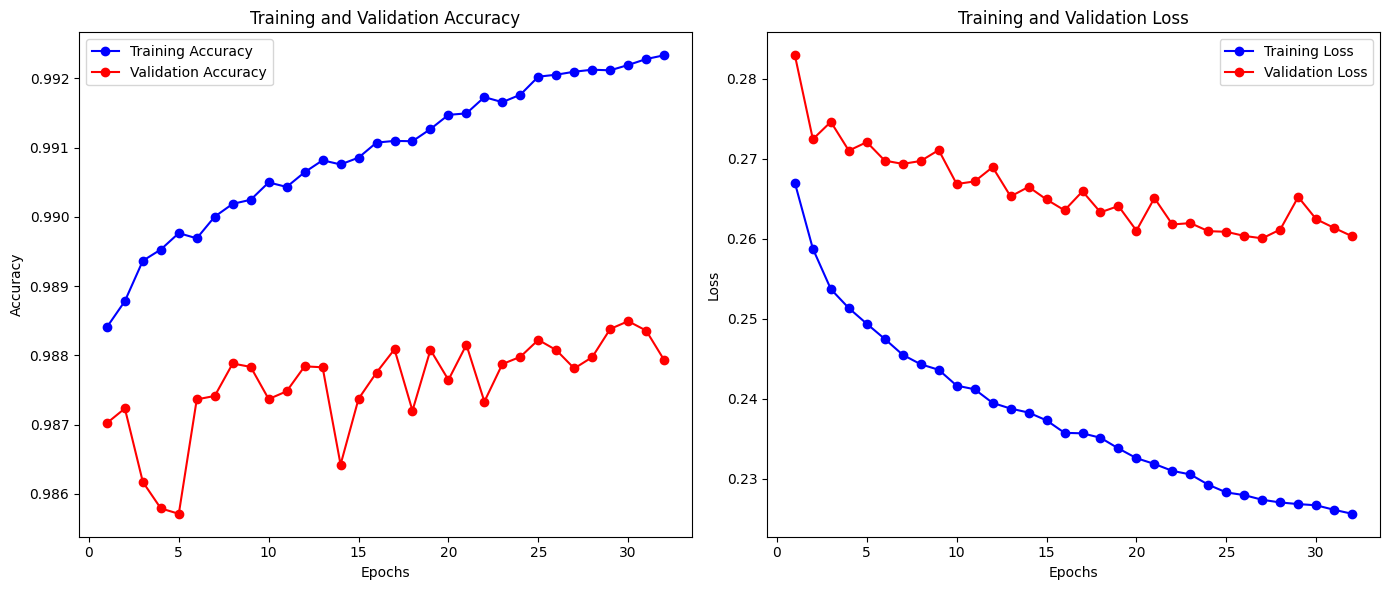

In [36]:
plot_training_history(history)

In [37]:
AU_model.save("attention_unet_model_early_stopping.keras")

In [38]:
from tensorflow.keras.models import load_model

AU_model = load_model(
    "attention_unet_model_early_stopping.keras",
    custom_objects={
        "combined_loss": combined_loss,
        "sparse_dice_loss": sparse_dice_loss
    }
)

In [39]:
val_loss, val_accuracy = AU_model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

2025-05-17 19:43:00.028298: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.9865 - loss: 0.2672

2025-05-17 19:43:01.301627: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9874 - loss: 0.2624
Validation Loss: 0.2600
Validation Accuracy: 0.9878


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step - accuracy: 0.9874 - loss: 0.2624
Validation Loss: 0.2600, Validation Accuracy: 0.9878
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


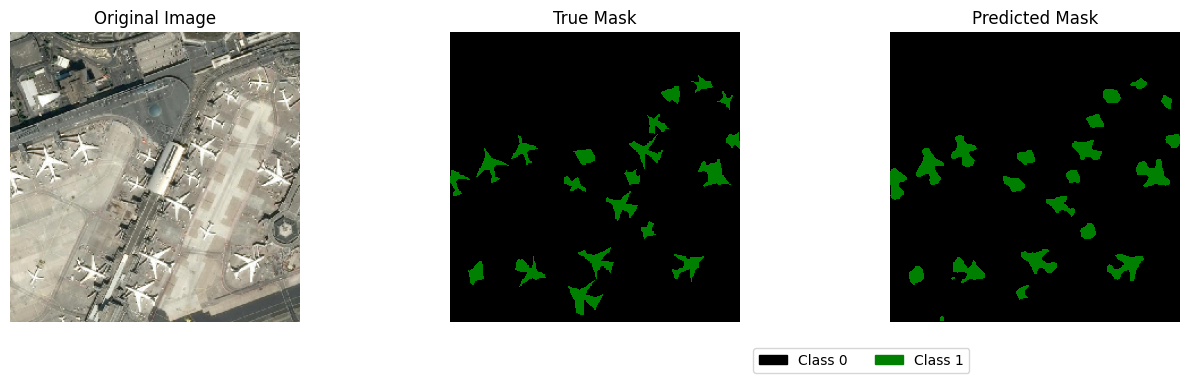

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Evaluate model
loss, accuracy = AU_model.evaluate(X_val, Y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Select sample
sample_index = 2
sample_image = X_val[sample_index]         # (256, 256, 3)
true_mask = Y_val[sample_index]            # (256, 256, 1) - class indices

# Predict
predicted_prob = AU_model.predict(np.expand_dims(sample_image, axis=0))[0]  # (256, 256, 2)
predicted_mask = np.argmax(predicted_prob, axis=-1)                         # (256, 256)
true_mask = np.squeeze(true_mask)                                           # (256, 256)

# Colormap for binary classes
cmap = mcolors.ListedColormap(['black', 'green'])  # class 0 = black, class 1 = green

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask, cmap=cmap)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap=cmap)
plt.axis('off')

# Legend
legend_labels = [
    mpatches.Patch(color='black', label='Class 0'),
    mpatches.Patch(color='green', label='Class 1')
]
plt.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(-0.1, -0.2), ncol=2)

plt.tight_layout()
plt.show()


In [41]:
def predict_and_visualize(model, dataset_images, index, original_paths=None, input_size=(256, 256)):
    import matplotlib.pyplot as plt
    import cv2
    from tensorflow.keras.preprocessing.image import img_to_array, load_img
    import numpy as np

    # Fetch the selected image
    image = dataset_images[index]

    # Expand dims for prediction
    input_img = np.expand_dims(image, axis=0)

    # Predict
    pred = model.predict(input_img)
    pred_mask = np.argmax(pred, axis=-1)[0]  # Shape: (H, W)

    # Load original image
    if original_paths is not None:
        image_path = original_paths[index]
        input_image = load_img(image_path, target_size=input_size)
        input_image = img_to_array(input_image).astype(np.uint8)
    else:
        input_image = (image * 255).astype(np.uint8)

    # Convert to BGR for OpenCV
    image_bgr = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)

    # Define class colors
    class_colors = {
        0: (128, 128, 128),  # Background
        1: (255, 0, 0),      # Boat
        2: (0, 0, 255),      # Aircraft
    }

    # Draw contours
    for class_index, color in class_colors.items():
        binary_mask = (pred_mask == class_index).astype(np.uint8) * 255

        # Optional: resize mask to match input image in case of mismatches
        if binary_mask.shape != input_image.shape[:2]:
            binary_mask = cv2.resize(binary_mask, input_size, interpolation=cv2.INTER_NEAREST)

        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(image_bgr, contours, -1, color, thickness=1)

    # Convert back to RGB
    final_image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(final_image_rgb)
    plt.title(f"Predicted Contours for Image {index}")
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


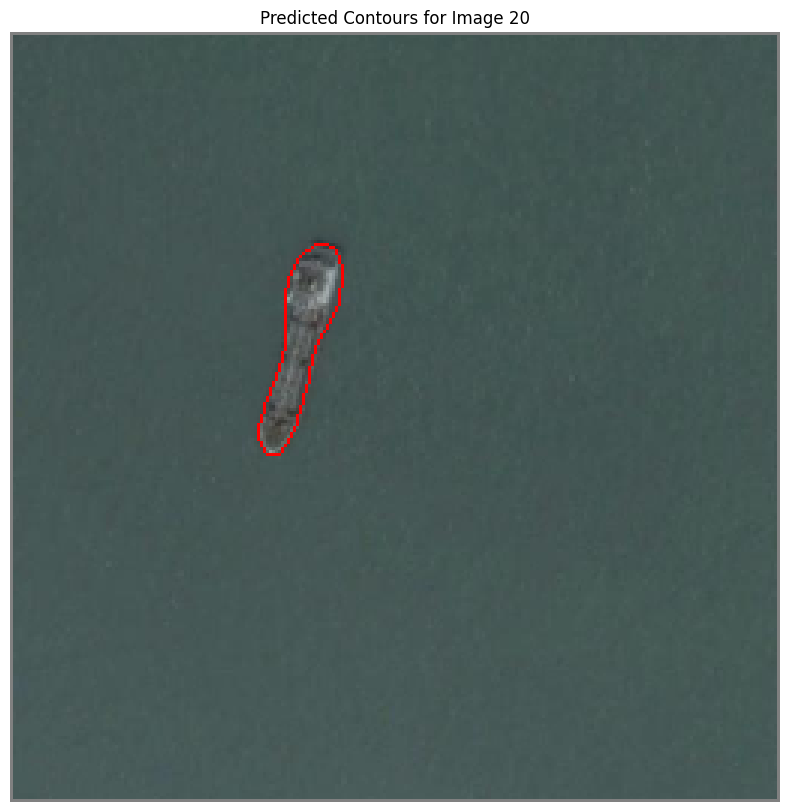

In [42]:
predict_and_visualize(AU_model, X_val, index=20)

In [43]:
val_loss, val_accuracy = AU_model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9865 - loss: 0.2672

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - accuracy: 0.9874 - loss: 0.2624
Validation Loss: 0.2600
Validation Accuracy: 0.9878


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


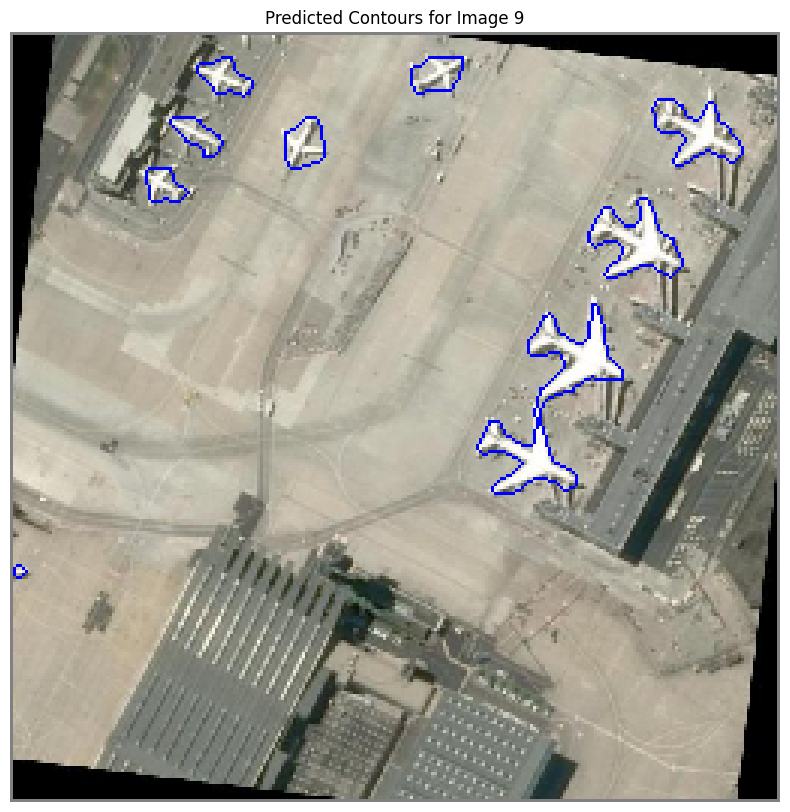

In [77]:
predict_and_visualize(AU_model, X_val, index=9)

In [45]:
def attention_block(x, gating, inter_shape):
    theta_x = Conv2D(inter_shape, (1, 1), strides=1, padding='same')(x)
    phi_g = Conv2D(inter_shape, (1, 1), strides=1, padding='same')(gating)

    if theta_x.shape[1] != phi_g.shape[1] or theta_x.shape[2] != phi_g.shape[2]:
        scale_h = tf.shape(theta_x)[1] // tf.shape(phi_g)[1]
        scale_w = tf.shape(theta_x)[2] // tf.shape(phi_g)[2]
        phi_g = UpSampling2D(size=(scale_h, scale_w), interpolation='bilinear')(phi_g)

    concat_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    y = Multiply()([x, sigmoid_xg])
    return y

In [46]:
from tensorflow.keras.layers import Conv2D, Multiply, Add, Activation, UpSampling2D, MaxPooling2D, concatenate, Input
from tensorflow.keras.models import Model
import tensorflow as tf
from deformable_conv_layer import DeformableConvLayer

def attention_unet_with_deformable_conv(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = DeformableConvLayer(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = DeformableConvLayer(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = DeformableConvLayer(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = DeformableConvLayer(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = DeformableConvLayer(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder with Attention and standard Conv2D
    up6 = UpSampling2D(size=(2, 2))(conv5)
    attn6 = attention_block(conv4, up6, 512)
    merge6 = concatenate([up6, attn6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    attn7 = attention_block(conv3, up7, 256)
    merge7 = concatenate([up7, attn7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    attn8 = attention_block(conv2, up8, 128)
    merge8 = concatenate([up8, attn8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    attn9 = attention_block(conv1, up9, 64)
    merge9 = concatenate([up9, attn9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(3, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='combined_loss', metrics=['accuracy'])

    return model

In [47]:
AUD_model = attention_unet_with_deformable_conv()
AUD_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deformable_conv_la… │ (None, 256, 256,  │      2,296 │ input_layer_1[0]… │
│ (DeformableConvLay… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 256, 256,  │     36,928 │ deformable_conv_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deformable_conv_la… │ (None, 128, 128,  │     84,242 │ max_pooling2d_4[… │
│ (DeformableConvLay… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 128, 128,  │    147,584 │ deformable_conv_… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_36[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deformable_conv_la… │ (None, 64, 64,    │    315,922 │ max_pooling2d_5[… │
│ (DeformableConvLay… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │    590,080 │ deformable_conv_… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deformable_conv_la… │ (None, 32, 32,    │  1,221,650 │ max_pooling2d_6[… │
│ (DeformableConvLay… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ deformable_conv_… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_42[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deformable_conv_la… │ (None, 16, 16,    │  4,802,578 │ max_pooling2d_7[… │
│ (DeformableConvLay… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ deformable_conv_… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_45[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 32, 32,    │    262,656 │ conv2d_42[0][0] 

 Total params: 32,582,535 (124.29 MB)

 Trainable params: 32,582,535 (124.29 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
from tensorflow.keras.optimizers import Adam

AUD_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=['accuracy']
)

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [50]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

history = AUD_model.fit(
    X_train,Y_train,
    epochs=100,
    batch_size=4,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_320']
Received: inputs=Tensor(shape=(4, 256, 256, 3))
Gradients do not exist for variables ['deformable_conv_layer/conv2d_31/kernel', 'deformable_conv_layer/conv2d_31/bias', 'deformable_conv_layer_1/conv2d_34/kernel', 'deformable_conv_layer_1/conv2d_34/bias', 'deformable_conv_layer_2/conv2d_37/kernel', 'deformable_conv_layer_2/conv2d_37/bias', 'deformable_conv_layer_3/conv2d_40/kernel', 'deformable_conv_layer_3/conv2d_40/bias', 'deformable_conv_layer_4/conv2d_43/kernel', 'deformable_conv_layer_4/conv2d_43/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8877 - loss: 0.8476

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_320']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
2025-05-17 19:43:41.356047: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-05-17 19:43:49.210819: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


61/61 ━━━━━━━━━━━━━━━━━━━━ 48s 358ms/step - accuracy: 0.8889 - loss: 0.8446 - val_accuracy: 0.9785 - val_loss: 0.6657 - learning_rate: 1.0000e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9779 - loss: 0.5014 - val_accuracy: 0.9785 - val_loss: 0.3854 - learning_rate: 1.0000e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9809 - loss: 0.3707 - val_accuracy: 0.9816 - val_loss: 0.3560 - learning_rate: 1.0000e-04
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9801 - loss: 0.3550 - val_accuracy: 0.9816 - val_loss: 0.3408 - learning_rate: 1.0000e-04
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9829 - loss: 0.3296 - val_accuracy: 0.9831 - val_loss: 0.3399 - learning_rate: 1.0000e-04
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9822 - loss: 0.3117 - val_accuracy: 0.9825 - val_loss: 0.3387 - learning_rate: 1.0000e-04
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.97

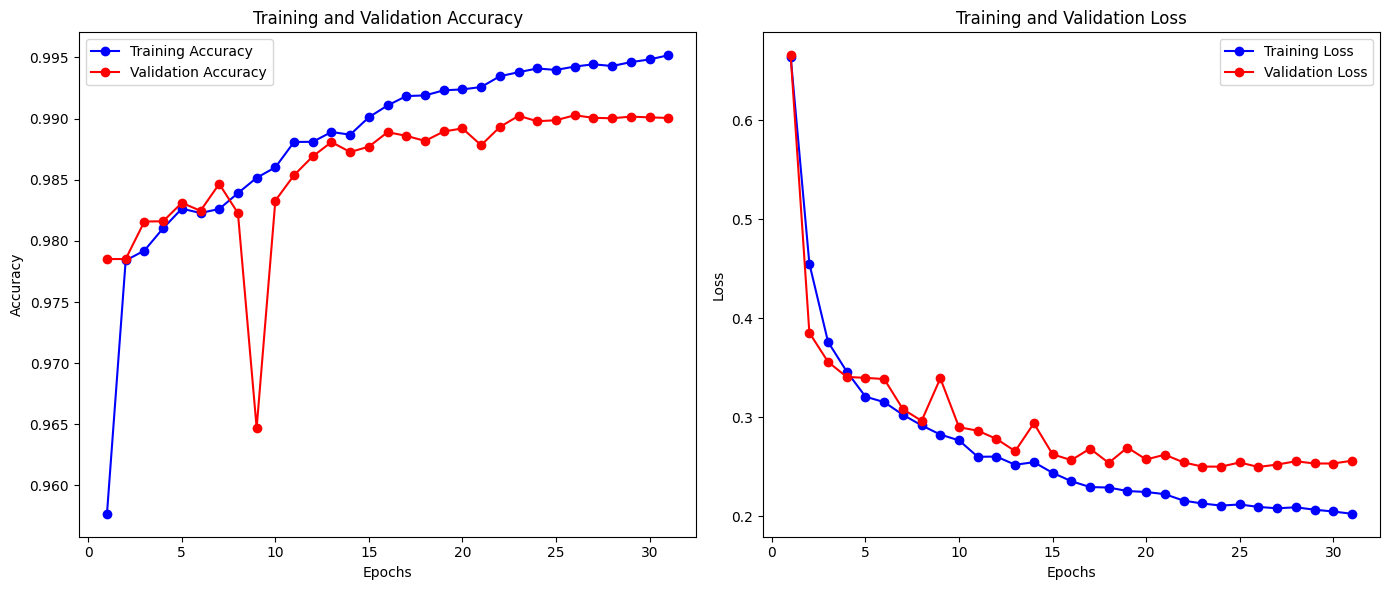

In [51]:
plot_training_history(history)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9865 - loss: 0.2672

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - accuracy: 0.9874 - loss: 0.2624
Validation Loss: 0.2600, Validation Accuracy: 0.9878


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_320']
Received: inputs=Tensor(shape=(1, 256, 256, 3))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


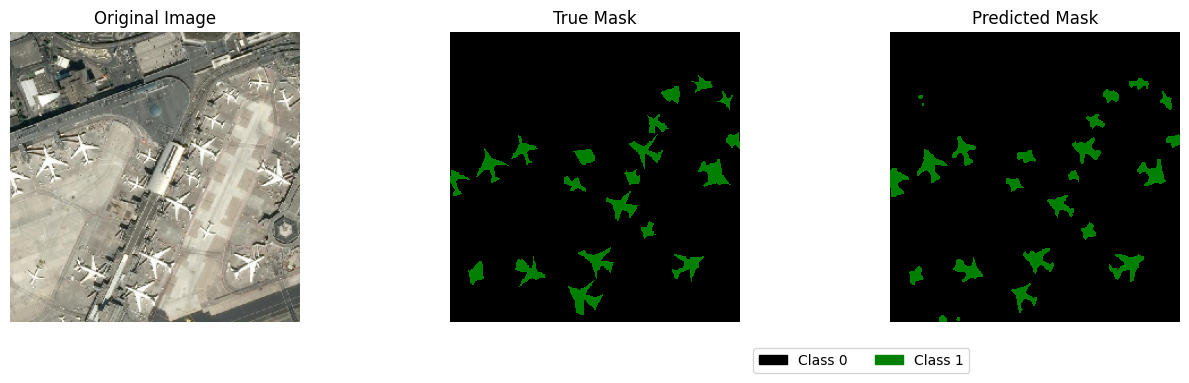

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Evaluate model
loss, accuracy = AU_model.evaluate(X_val, Y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Select sample
sample_index = 2
sample_image = X_val[sample_index]         # (256, 256, 3)
true_mask = Y_val[sample_index]            # (256, 256, 1) - class indices

# Predict
predicted_prob = AUD_model.predict(np.expand_dims(sample_image, axis=0))[0]  # (256, 256, 2)
predicted_mask = np.argmax(predicted_prob, axis=-1)                         # (256, 256)
true_mask = np.squeeze(true_mask)                                           # (256, 256)

# Colormap for binary classes
cmap = mcolors.ListedColormap(['black', 'green'])  # class 0 = black, class 1 = green

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask, cmap=cmap)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap=cmap)
plt.axis('off')

# Legend
legend_labels = [
    mpatches.Patch(color='black', label='Class 0'),
    mpatches.Patch(color='green', label='Class 1')
]
plt.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(-0.1, -0.2), ncol=2)

plt.tight_layout()
plt.show()


In [53]:
AUD_model.save("deformable_conv_unet-v2.keras")

In [54]:
from tensorflow.keras.models import load_model

AUD_model = load_model(
    "deformable_conv_unet-v2.keras",
    custom_objects={
        "combined_loss": combined_loss,
        "sparse_dice_loss": sparse_dice_loss,
        "DeformableConvLayer": DeformableConvLayer,
    }
)

`build()` was called on layer 'deformable_conv_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
`build()` was called on layer 'deformable_conv_layer_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
`build()` was called on layer 'deformable_conv_layer_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
`bu

In [55]:
val_loss, val_accuracy = AUD_model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

2025-05-17 19:48:42.430190: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9893 - loss: 0.2570

2025-05-17 19:48:43.727075: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9900 - loss: 0.2522
Validation Loss: 0.2499
Validation Accuracy: 0.9903


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


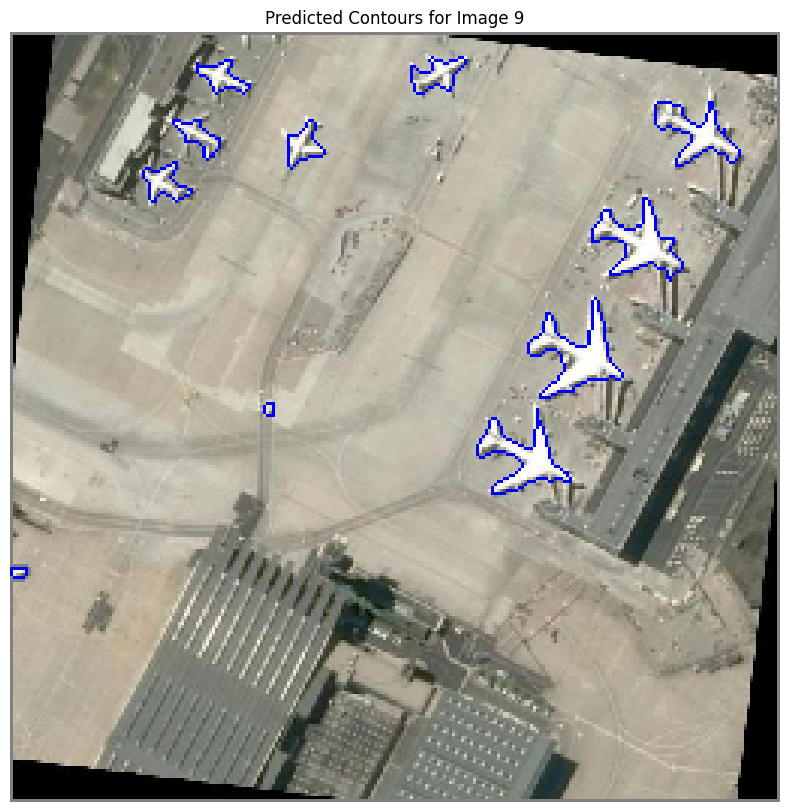

In [76]:
predict_and_visualize(AUD_model, X_val, index=9)

In [57]:
def predict_and_visualize_single_image(model, image_path, input_size=(256, 256)):
    import matplotlib.pyplot as plt
    import cv2
    from tensorflow.keras.preprocessing.image import img_to_array, load_img
    import numpy as np

    # Load and preprocess image
    input_image = load_img(image_path, target_size=input_size)
    input_image = img_to_array(input_image) / 255.0
    input_img = np.expand_dims(input_image, axis=0)  # Add batch dimension

    # Predict
    pred = model.predict(input_img)
    pred_mask = np.argmax(pred, axis=-1)[0]  # Remove batch dimension

    # Convert to uint8 for visualization
    vis_image = (input_image * 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR)

    # Define class colors
    class_colors = {
        0: (128, 128, 128),  # Background
        1: (255, 0, 0),      # Boat
        2: (0, 0, 255),      # Aircraft
    }

    # Draw contours for each class
    for class_index, color in class_colors.items():
        binary_mask = (pred_mask == class_index).astype(np.uint8) * 255
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(image_bgr, contours, -1, color, thickness=1)

    final_image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(final_image_rgb)
    plt.title(f"Predicted Contours")
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


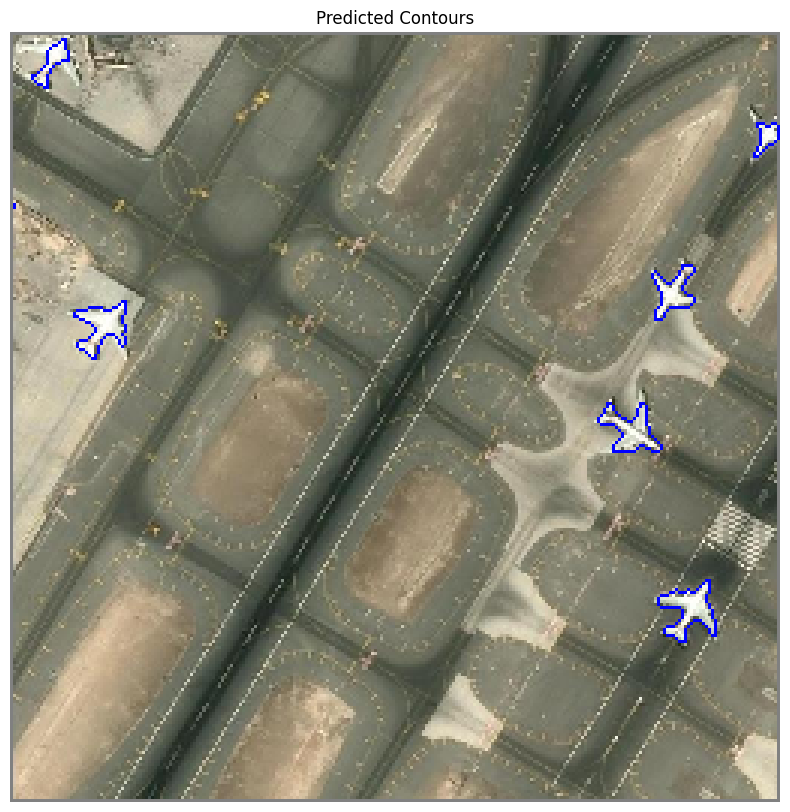

In [91]:
predict_and_visualize_single_image(AUD_model, "/teamspace/studios/this_studio/MiniProject-2/4e9164aa-532e-4b76-bce4-060b090da357_1060_1060_jpg.rf.c55dc54c47a17ced81170ceda6aecf82.jpg")